In [1]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import (BatchNormalization, Input, Dense, Activation)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow_probability as tfp
import seaborn as sns

pi = math.pi
maxval = 1e9
minval = 1e-9

In [2]:
train_df = pd.read_csv('./train1Dx_df.csv')
test_df = pd.read_csv('./test1Dx_df.csv')
print(train_df.shape, test_df.shape)

(1991564, 24) (125498, 24)


In [3]:
def inverse_cot(cota):
    a = np.arctan(1/cota)
    a[np.where(a<0)] = a[np.where(a<0)]+pi
    return a

In [4]:
X_train = train_df.drop(columns=['y-local','x-midplane','cotAlpha']).values
X_test = test_df.drop(columns=['y-local','x-midplane','cotAlpha']).values

y_train = inverse_cot(abs(train_df['cotAlpha'].values))*2/pi
y_test = inverse_cot(abs(test_df['cotAlpha'].values))*2/pi

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_3255/2672626872.py:2: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1/cota)


In [5]:
X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])

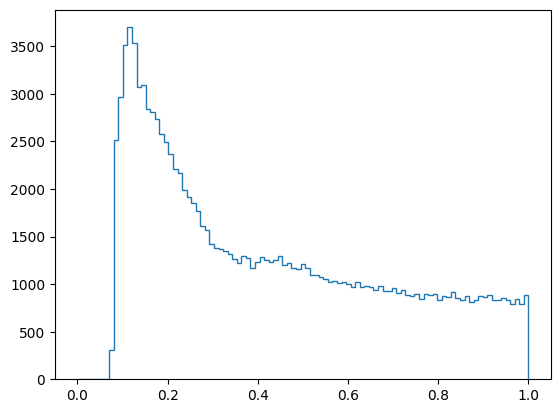

In [6]:
plt.hist(y_test,bins=np.linspace(0,1,100), histtype = 'step');

In [7]:
def param_transform(par):
    return minval+tf.math.softplus(par)

def log_beta(x, alpha, beta, a=0.0, b=10.0):
    # x in (0, 1), alpha > 0, beta > 0, a < x < b
    return (alpha - 1.0)*tf.math.log(x - a) + (beta - 1.0)*tf.math.log(b - x) \
            - tf.math.lgamma(alpha) - tf.math.lgamma(beta) + tf.math.lgamma(alpha + beta) \
            - (alpha + beta - 1.)*tf.math.log(b - a)

def beta_loss(y, p):
    
    alpha = param_transform(tf.gather(params=p, indices=[0], axis=1))
    beta = param_transform(tf.gather(params=p, indices=[1], axis=1))
    
    NLL = -1*log_beta(y, alpha, beta)
    return tf.keras.backend.sum(NLL,axis=1)

In [8]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("elu", name="elu1")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense2")(x)
    x = Activation("elu", name="elu2")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense3")(x)
    x = Activation("elu", name="elu3")(x)
    x = BatchNormalization()(x)
    x = Dense(2, name="dense4")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.0025),
              loss=beta_loss)

model.summary()

2023-02-16 10:06:18.971279: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-16 10:06:18.971299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                1408      
                                                                 
 elu1 (Activation)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 
 elu2 (Activation)           (None, 64)                0         
                               

In [9]:
es = EarlyStopping(patience=10,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=500, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/500


2023-02-16 10:06:19.408817: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-16 10:06:19.840072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1556/1556 [==============================] - ETA: 0s - loss: -0.3923

2023-02-16 10:06:52.403888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1556/1556 [==============================] - 36s 23ms/step - loss: -0.3923 - val_loss: -1.1023
Epoch 2/500
1556/1556 [==============================] - 35s 23ms/step - loss: -1.2559 - val_loss: -1.5565
Epoch 3/500
1556/1556 [==============================] - 36s 23ms/step - loss: -1.4741 - val_loss: -1.7442
Epoch 4/500
1556/1556 [==============================] - 35s 23ms/step - loss: -1.5476 - val_loss: -1.8223
Epoch 5/500
1556/1556 [==============================] - 36s 23ms/step - loss: -1.5713 - val_loss: -1.7969
Epoch 6/500
1556/1556 [==============================] - 35s 22ms/step - loss: -1.5823 - val_loss: -1.8893
Epoch 7/500
1556/1556 [==============================] - 35s 22ms/step - loss: -1.5883 - val_loss: -1.9204
Epoch 8/500
1556/1556 [==============================] - 35s 22ms/step - loss: -1.5917 - val_loss: -1.9311
Epoch 9/500
1556/1556 [==============================] - 35s 22ms/step - loss: -1.5938 - val_loss: -1.9386
Epoch 10/500
1556/1556 [=========================

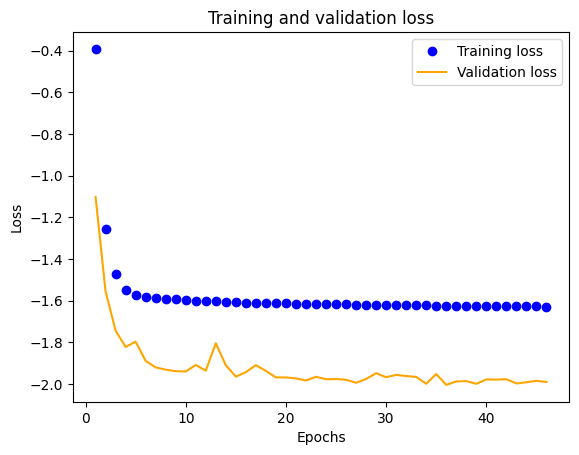

In [10]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('Log')
plt.legend()
plt.show()

In [12]:
p_test = model.predict(X_test, batch_size= 512)
df = pd.DataFrame(p_test,columns=['par1','par2'])
df['Atrue'] = y_test*pi/2
df['alpha'] = param_transform(df['par1'])
df['beta'] = param_transform(df['par2'])

a,b = 0.0,10.0
df['mean'] = (df['alpha']/ (df['alpha']+ df['beta']))*(b-a)
df['mode'] = a + ((df['alpha'] - 1.0)/ (df['alpha']+df['beta']-2.0))*(b-a)

df['var'] = (((df['alpha']*df['beta'])*(b-a)**2))/((df['alpha']+df['beta']+1.0)*(df['alpha']+df['beta'])**2)
df['sigma'] = np.sqrt(df['var'])
# dist = tfp.distributions.Beta(concentration1 = df['alpha'], concentration0 = df['beta'])
    
df['mean'] = df['mean']*pi/2
df['mode'] = df['mode']*pi/2
df['sigma'] = df['sigma']*pi/2

# df.to_csv("test_1DcotABeta.csv",header=False,index=False)

246/246 [==============================] - 1s 4ms/step


In [13]:
residuals = df['Atrue'] - df['mode']
print(np.mean(residuals),np.std(residuals))

0.011386443515986888 0.0779137159130687


/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_3255/2291133400.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


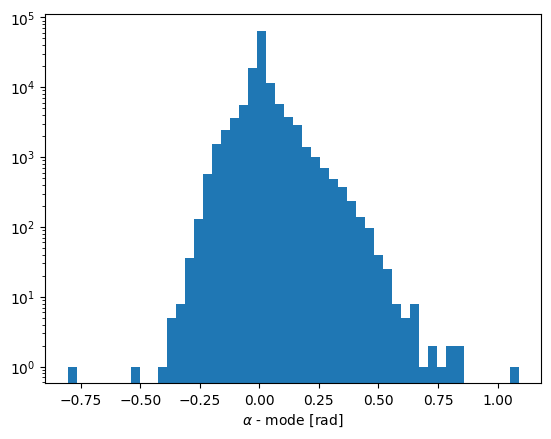

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_3255/2291133400.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


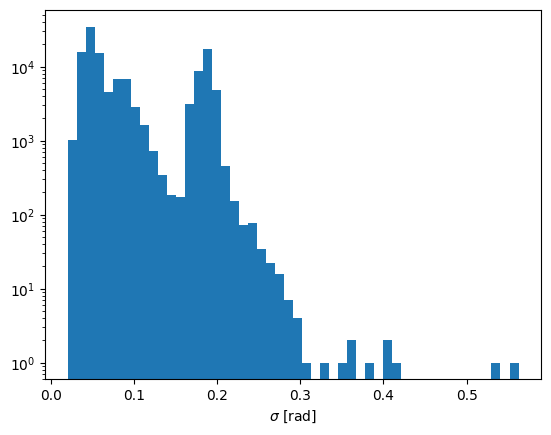

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_3255/2291133400.py:12: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


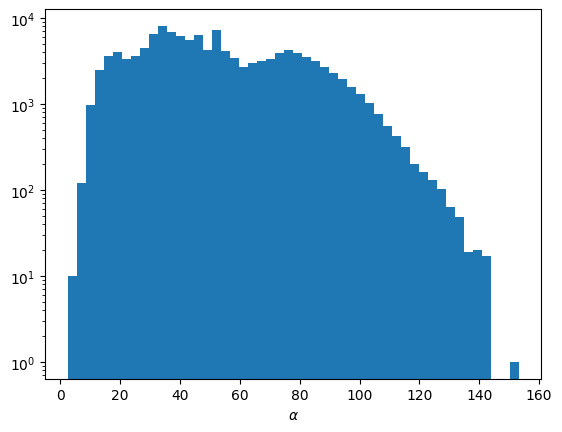

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_3255/2291133400.py:17: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


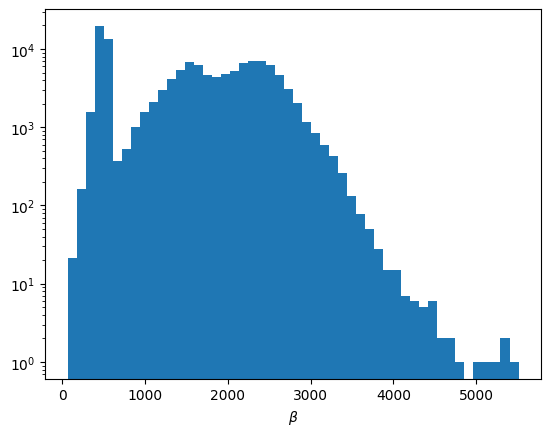

In [14]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$\alpha$ - mode [rad]')
plt.show()

plt.hist(df['sigma'],bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [rad]')
plt.show()

plt.hist(df['alpha'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\alpha$')
plt.show()

plt.hist(df['beta'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$')
plt.show()

Text(0, 0.5, 'log(beta)')

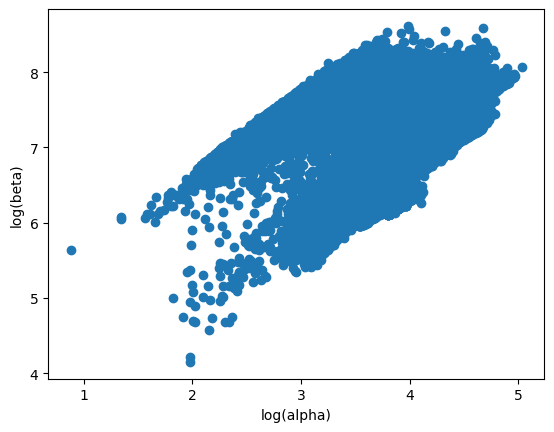

In [15]:
plt.scatter(np.log(df['alpha']),np.log(df['beta']))
plt.xlabel('log(alpha)')
plt.ylabel('log(beta)')

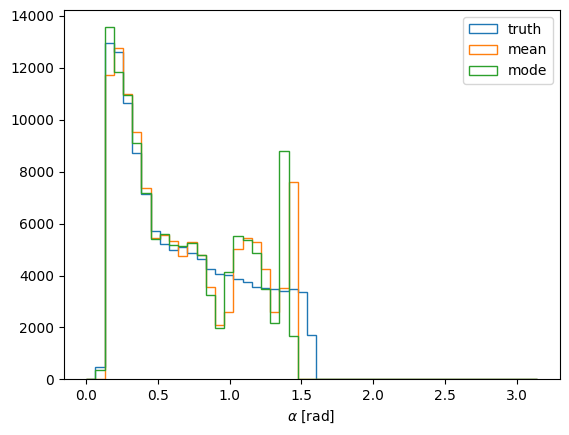

In [16]:
plt.hist(df['Atrue'],bins=np.linspace(0,pi,50),histtype='step',label='truth')
plt.hist(df['mean'],bins=np.linspace(0,pi,50),histtype='step',label='mean')
plt.hist(df['mode'],bins=np.linspace(0,pi,50),histtype='step',label='mode')
# plt.yscale('Log')
plt.xlabel(r'$\alpha$ [rad]')
# plt.xlim([0.0,pi])
plt.legend()
plt.show()

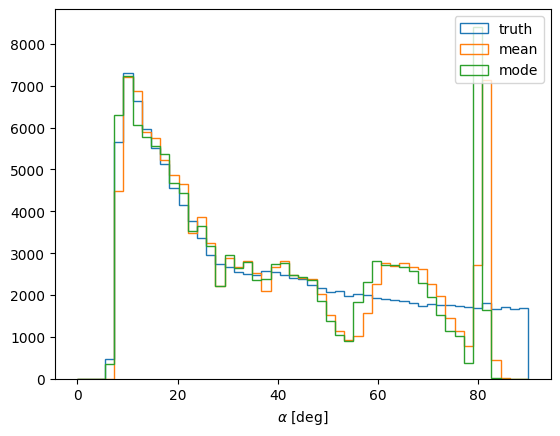

In [17]:
plt.hist(df['Atrue']*180/pi,bins=np.linspace(0,90,50),histtype='step',label='truth')
plt.hist(df['mean']*180/pi,bins=np.linspace(0,90,50),histtype='step',label='mean')
plt.hist(df['mode']*180/pi,bins=np.linspace(0,90,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\alpha$ [deg]')
plt.legend()
plt.show()

Text(0, 0.5, '$\\alpha$ - mode [rad]')

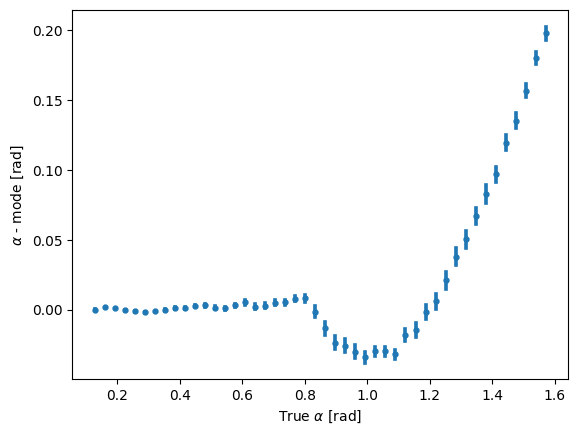

In [18]:
x = sns.regplot(x=df['Atrue'], y=df['Atrue']-df['mode'], x_bins=np.linspace(0,pi/2,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\alpha$ [rad]')
plt.ylabel(r'$\alpha$ - mode [rad]')

Text(0, 0.5, '$\\alpha$ - mode [deg]')

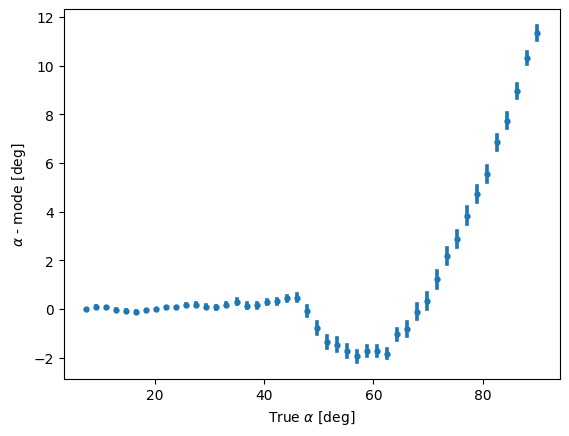

In [19]:
x = sns.regplot(x=df['Atrue']*180/pi, y=(df['Atrue']-df['mode'])*180/pi, x_bins=np.linspace(0,90,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\alpha$ [deg]')
plt.ylabel(r'$\alpha$ - mode [deg]')

Text(0, 0.5, '$\\sigma$ [rad]')

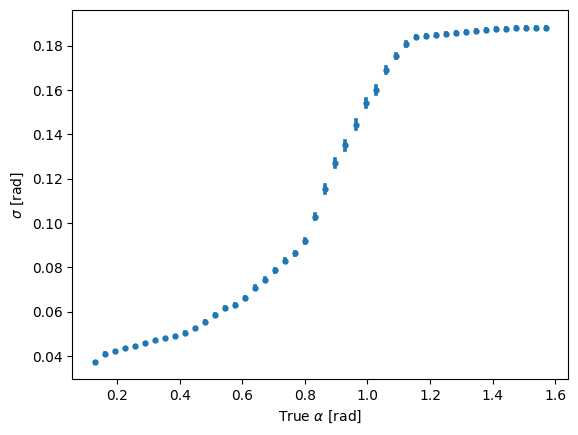

In [20]:
y = sns.regplot(x=df['Atrue'], y=df['sigma'], x_bins=np.linspace(0,pi/2,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\alpha$ [rad]')
plt.ylabel(r'$\sigma$ [rad]')

Text(0, 0.5, '$\\sigma$ [deg]')

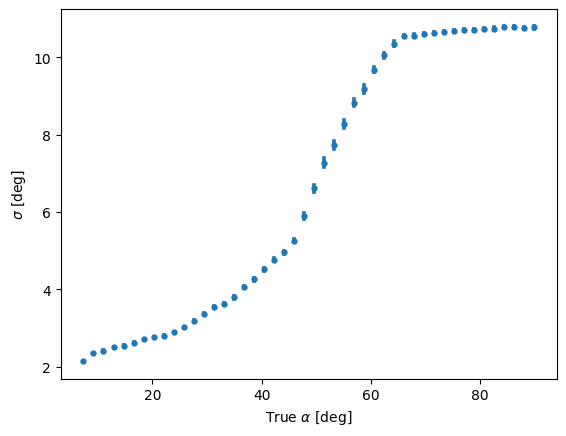

In [21]:
y = sns.regplot(x=df['Atrue']*180/pi, y=df['sigma']*180/pi, x_bins=np.linspace(0,90,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\alpha$ [deg]')
plt.ylabel(r'$\sigma$ [deg]')

Text(0, 0.5, 'Param value')

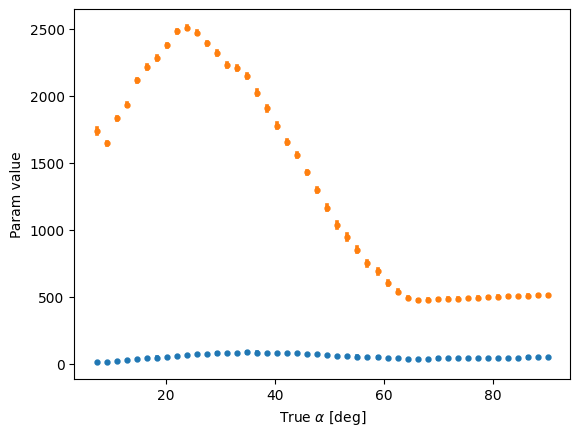

In [22]:
sns.regplot(x=df['Atrue']*180/pi, y=df['alpha'], x_bins=np.linspace(0,90,50), fit_reg=None, marker='.',label='$\alpha$')
sns.regplot(x=df['Atrue']*180/pi, y=df['beta'], x_bins=np.linspace(0,90,50), fit_reg=None, marker='.',label='$\beta$')
plt.xlabel(r'True $\alpha$ [deg]')
plt.ylabel('Param value')
#plt.legend()

0.09819765510677951 0.5354146598326714


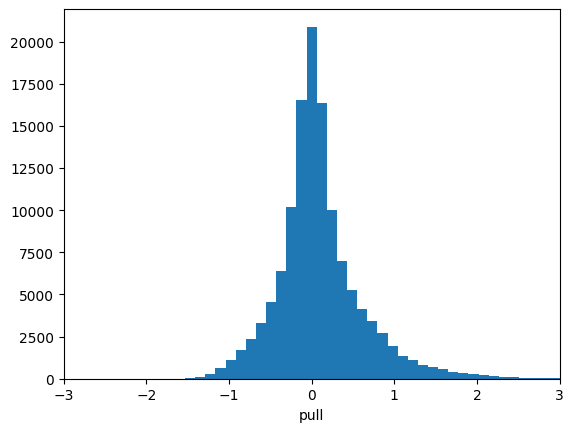

In [23]:
pulls = residuals/df['sigma']
print(np.mean(pulls),np.std(pulls))
plt.hist(pulls,bins=np.linspace(-3,3,50));
plt.xlabel('pull')
plt.xlim([-3,3])
plt.show()